In [1]:
!pip install opendatasets --upgrade --quiet

# {"username":"kavyag2023","key":"0beb83ff9985a30d69b6dfd529b2ee7c"}

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kavyag2023
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:02<00:00, 148MB/s]


The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [3]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [4]:
print(os.listdir(DATA_DIR+'/images')[:10])

['55997_2017.jpg', '44542_2013.jpg', '29194_2010.jpg', '2361_2001.jpg', '52673_2016.jpg', '8454_2004.jpg', '59665_2018.jpg', '60435_2018.jpg', '46259_2014.jpg', '7878_2004.jpg']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


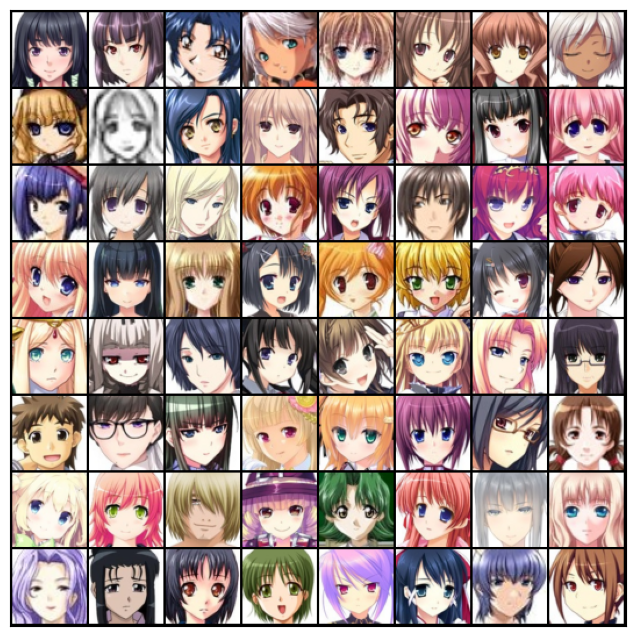

In [11]:
show_batch(train_dl)

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

In [15]:
import torch.nn as nn

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


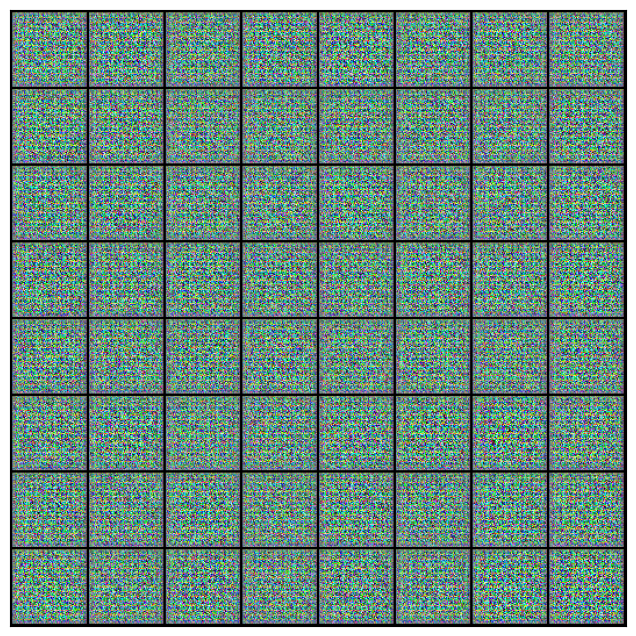

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

In [22]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [23]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [24]:
from torchvision.utils import save_image

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


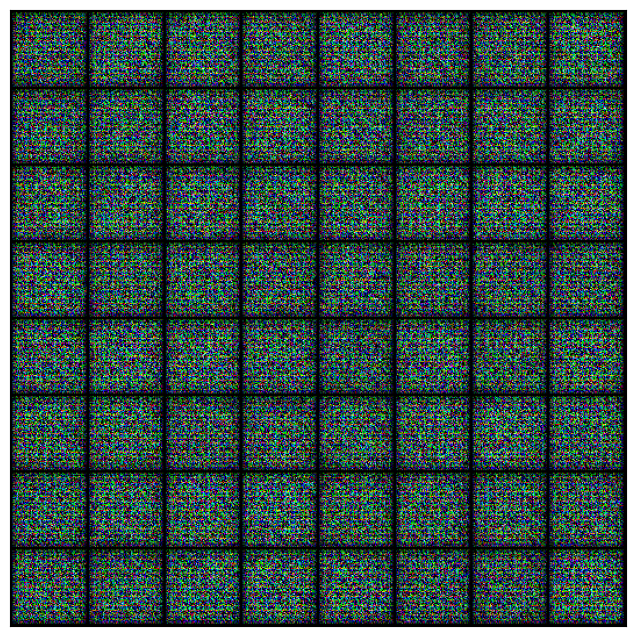

In [28]:
save_samples(0, fixed_latent)

In [29]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0002
epochs = 50

In [32]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 5.8077, loss_d: 0.4523, real_score: 0.8618, fake_score: 0.2250
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.1918, loss_d: 0.4189, real_score: 0.8099, fake_score: 0.1490
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 8.2853, loss_d: 0.5893, real_score: 0.9883, fake_score: 0.3787
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 5.8234, loss_d: 0.3457, real_score: 0.8835, fake_score: 0.1596
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 5.0258, loss_d: 0.2875, real_score: 0.8534, fake_score: 0.0770
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 10.7148, loss_d: 0.2334, real_score: 0.9941, fake_score: 0.1833
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 13.7747, loss_d: 0.0775, real_score: 0.9348, fake_score: 0.0002
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 4.8202, loss_d: 0.0404, real_score: 0.9916, fake_score: 0.0302
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 13.5021, loss_d: 0.3066, real_score: 0.9863, fake_score: 0.1956
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 5.5002, loss_d: 0.0695, real_score: 0.9531, fake_score: 0.0173
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 13.8224, loss_d: 0.0902, real_score: 0.9477, fake_score: 0.0000
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 6.5582, loss_d: 0.0081, real_score: 0.9991, fake_score: 0.0070
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 6.4417, loss_d: 0.6506, real_score: 0.6585, fake_score: 0.0004
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 6.8308, loss_d: 0.0674, real_score: 0.9530, fake_score: 0.0124
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 18.3260, loss_d: 0.1566, real_score: 0.9227, fake_score: 0.0000
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 9.5222, loss_d: 0.2298, real_score: 0.8549, fake_score: 0.0001
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 9.3066, loss_d: 0.0232, real_score: 0.9999, fake_score: 0.0211
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 5.7922, loss_d: 0.0651, real_score: 0.9744, fake_score: 0.0347
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 6.8515, loss_d: 0.0759, real_score: 0.9818, fake_score: 0.0519
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 8.0106, loss_d: 0.0936, real_score: 0.9906, fake_score: 0.0749
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 5.8394, loss_d: 0.0688, real_score: 0.9591, fake_score: 0.0148
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 11.3959, loss_d: 0.0147, real_score: 0.9914, fake_score: 0.0054
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 20.3487, loss_d: 0.3534, real_score: 0.9907, fake_score: 0.2253
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 5.4345, loss_d: 0.0508, real_score: 0.9674, fake_score: 0.0107
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 7.2556, loss_d: 0.1143, real_score: 0.9597, fake_score: 0.0601
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 5.4044, loss_d: 0.0694, real_score: 0.9710, fake_score: 0.0141
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 6.0577, loss_d: 0.0429, real_score: 0.9771, fake_score: 0.0177
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 4.8904, loss_d: 0.0368, real_score: 0.9803, fake_score: 0.0143
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 6.4320, loss_d: 0.0954, real_score: 0.9854, fake_score: 0.0718
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 13.7298, loss_d: 0.0068, real_score: 0.9944, fake_score: 0.0011
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 5.7101, loss_d: 0.0585, real_score: 0.9644, fake_score: 0.0134
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 10.0416, loss_d: 0.0432, real_score: 0.9976, fake_score: 0.0371
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.8599, loss_d: 0.0265, real_score: 0.9888, fake_score: 0.0135
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 7.1778, loss_d: 0.0342, real_score: 0.9969, fake_score: 0.0294
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 6.2114, loss_d: 0.0699, real_score: 0.9659, fake_score: 0.0257
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 5.3313, loss_d: 0.0418, real_score: 0.9846, fake_score: 0.0250
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 9.0154, loss_d: 0.0677, real_score: 0.9470, fake_score: 0.0016
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 27.6274, loss_d: 0.0656, real_score: 0.9743, fake_score: 0.0192
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.8015, loss_d: 0.0450, real_score: 0.9688, fake_score: 0.0088
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 5.1549, loss_d: 0.0218, real_score: 0.9916, fake_score: 0.0127
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 6.9647, loss_d: 0.0982, real_score: 0.9253, fake_score: 0.0032
Saving generated-images-0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 5.8054, loss_d: 0.0307, real_score: 0.9887, fake_score: 0.0159
Saving generated-images-0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.3609, loss_d: 0.1118, real_score: 0.9385, fake_score: 0.0091
Saving generated-images-0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 6.9382, loss_d: 0.0590, real_score: 0.9872, fake_score: 0.0441
Saving generated-images-0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 17.5215, loss_d: 0.0499, real_score: 0.9622, fake_score: 0.0024
Saving generated-images-0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 5.4598, loss_d: 0.0542, real_score: 0.9681, fake_score: 0.0134
Saving generated-images-0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 13.9697, loss_d: 0.0211, real_score: 0.9811, fake_score: 0.0003
Saving generated-images-0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 26.0891, loss_d: 0.0004, real_score: 0.9998, fake_score: 0.0002
Saving generated-images-0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 31.6596, loss_d: 0.0578, real_score: 0.9750, fake_score: 0.0000
Saving generated-images-0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 5.2239, loss_d: 0.0499, real_score: 0.9641, fake_score: 0.0060
Saving generated-images-0050.png


In [33]:
losses_g, losses_d, real_scores, fake_scores = history

In [34]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

import torch
import torch.nn as nn

# Define the generator and discriminator architectures (similar to how they were defined before)

# Initialize the generator and discriminator models
generator = ...  # Define your generator model architecture
discriminator = ...  # Define your discriminator model architecture

# Load the saved state dictionaries for the generator and discriminator
generator_state_dict = torch.load('G.pth')
discriminator_state_dict = torch.load('D.pth')

# Load the state dictionaries into the models
generator.load_state_dict(generator_state_dict)
discriminator.load_state_dict(discriminator_state_dict)

# Set the models to evaluation mode (no gradient calculation during inference)
generator.eval()
discriminator.eval()

# Example input data (replace this with your actual input data)
input_data = torch.randn(batch_size, input_size)

# Pass input data through the generator model for inference
generated_images = generator(input_data)

# Pass input data through the discriminator model for inference
output_scores = discriminator(input_data)


AttributeError: 'ellipsis' object has no attribute 'load_state_dict'

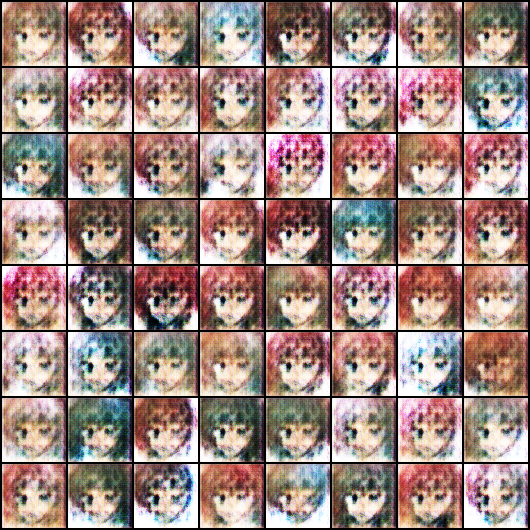

In [35]:
from IPython.display import Image
Image('./generated/generated-images-0001.png')

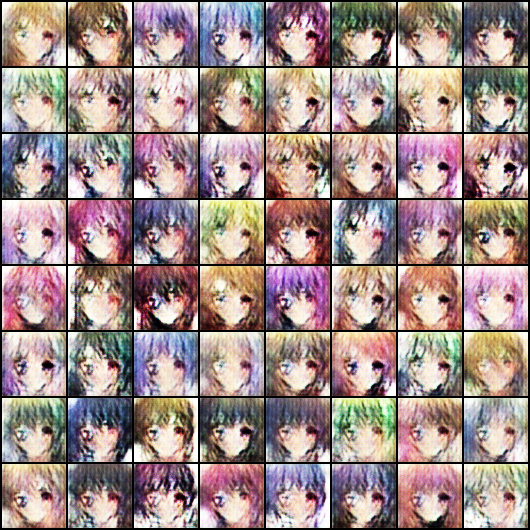

In [36]:
Image('./generated/generated-images-0002.png')

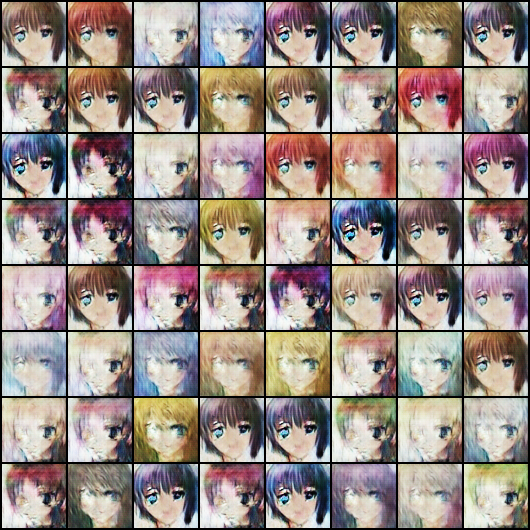

In [37]:
Image('./generated/generated-images-0049.png')